### END TO END EXPLORATORY DATA ANALYSIS PROJECT

This project walks through extracting and transforming data from northwind database
and using that in our analysis. The goal of the project is listed as follows:

1. Create a secure database connection
2. Create a data streaming pipeline
3. Perform exploratory data analysis.



#### Import the libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import mysql.connector
from mysql.connector import Error
from IPython.display import clear_output

In [3]:
!pip install mysql-connector-python

In [7]:
# set up the function for database connection

def connect_database(user_name,host_name,db_name,db_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host = host_name,
            user = user_name,
            passwd = db_password,
            database = db_name
        )
        print(f'Connected to database {db_name} successfully')

    except Error as err:
        print(f'Error: {err}')

    return connection


host_name = input()
user_name = input()
db_password = input()
db_name =  input()

clear_output()

connection = connect_database(user_name,host_name,db_name,db_password)

Connected to database northwind successfully


###  Analysis of Northwind Dataset with SQL and Python
1. Evaluate the delivery performance of each shipping companies for deliveries made to USA

In [11]:
# create a streaming pipeline

def read_query(query, connection):
    result = None
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Error as err:
        print(f'Error: {err}')

    return result

In [13]:
delivery_performance_query= '''
select companyname, count(*) as total_deliveries,
sum(case when shippeddate <= requireddate then 1 else 0 end) as on_time_deliveries,
sum(case when shippeddate > requireddate then 1 else 0 end) as late_deliveries
from orders
join shippers on shipvia = shipperid
where shipcountry = 'USA' and ShippedDate is not null
group by companyname;
'''

data = read_query(query=delivery_performance_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

delivery_performance_df = pd.DataFrame(data=data_list, columns=['companyname', 'total_deliveries', 'on_time_deliveries', 'late_deliveries'])
delivery_performance_df

,companyname,total_deliveries,on_time_deliveries,late_deliveries
0,Federal Shipping,38,37,1
1,Speedy Express,31,29,2
2,United Package,50,46,4


In [15]:
delivery_performance_rate_query= '''
select companyname, count(*)  as total_deliveries,
sum(case when shippeddate <= requireddate then 1 else 0 end) as on_time_deliveries,
sum(case when shippeddate > requireddate then 1 else 0 end) as late_deliveries, 
round((sum(case when shippeddate <= requireddate then 1 else 0 end))/(count(shippeddate))*100, 0)as on_time_delivery_rate,
round((sum(case when shippeddate > requireddate then 1 else 0 end))/(count(shippeddate))*100, 0)as late_delivery_rate
from orders
join shippers on shipvia = shipperid
where shipcountry = 'USA' and ShippedDate is not null
group by companyname; 
'''

data = read_query(query=delivery_performance_rate_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

delivery_performance_rate_df = pd.DataFrame(data=data_list, columns=['companyname', 'total_deliveries', 'on_time_deliveries', 'late_deliveries',
                                                                'on_time_delivery_rate','late_delivery_rate'])
delivery_performance_rate_df

,companyname,total_deliveries,on_time_deliveries,late_deliveries,on_time_delivery_rate,late_delivery_rate
0,Federal Shipping,38,37,1,97,3
1,Speedy Express,31,29,2,94,6
2,United Package,50,46,4,92,8


In [19]:
#inspect null values
delivery_performance_rate_df.isnull().sum()

companyname              0
total_deliveries         0
on_time_deliveries       0
late_deliveries          0
on_time_delivery_rate    0
late_delivery_rate       0
dtype: int64

In [21]:
# inspect the data qualities
delivery_performance_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   companyname            3 non-null      object
 1   total_deliveries       3 non-null      int64 
 2   on_time_deliveries     3 non-null      object
 3   late_deliveries        3 non-null      object
 4   on_time_delivery_rate  3 non-null      object
 5   late_delivery_rate     3 non-null      object
dtypes: int64(1), object(5)
memory usage: 276.0+ bytes


In [25]:
# Specify desired data types

convert_dict = {'late_deliveries': int, 'on_time_deliveries' : int,'on_time_delivery_rate' : int, 'late_delivery_rate' : int}  
delivery_performance_rate_df = delivery_performance_rate_df.astype(convert_dict)

In [29]:
 # check datatype

delivery_performance_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   companyname            3 non-null      object
 1   total_deliveries       3 non-null      int64 
 2   on_time_deliveries     3 non-null      int32 
 3   late_deliveries        3 non-null      int32 
 4   on_time_delivery_rate  3 non-null      int32 
 5   late_delivery_rate     3 non-null      int32 
dtypes: int32(4), int64(1), object(1)
memory usage: 228.0+ bytes


Text(0.5, 1.0, 'companyname by total_deliveries')

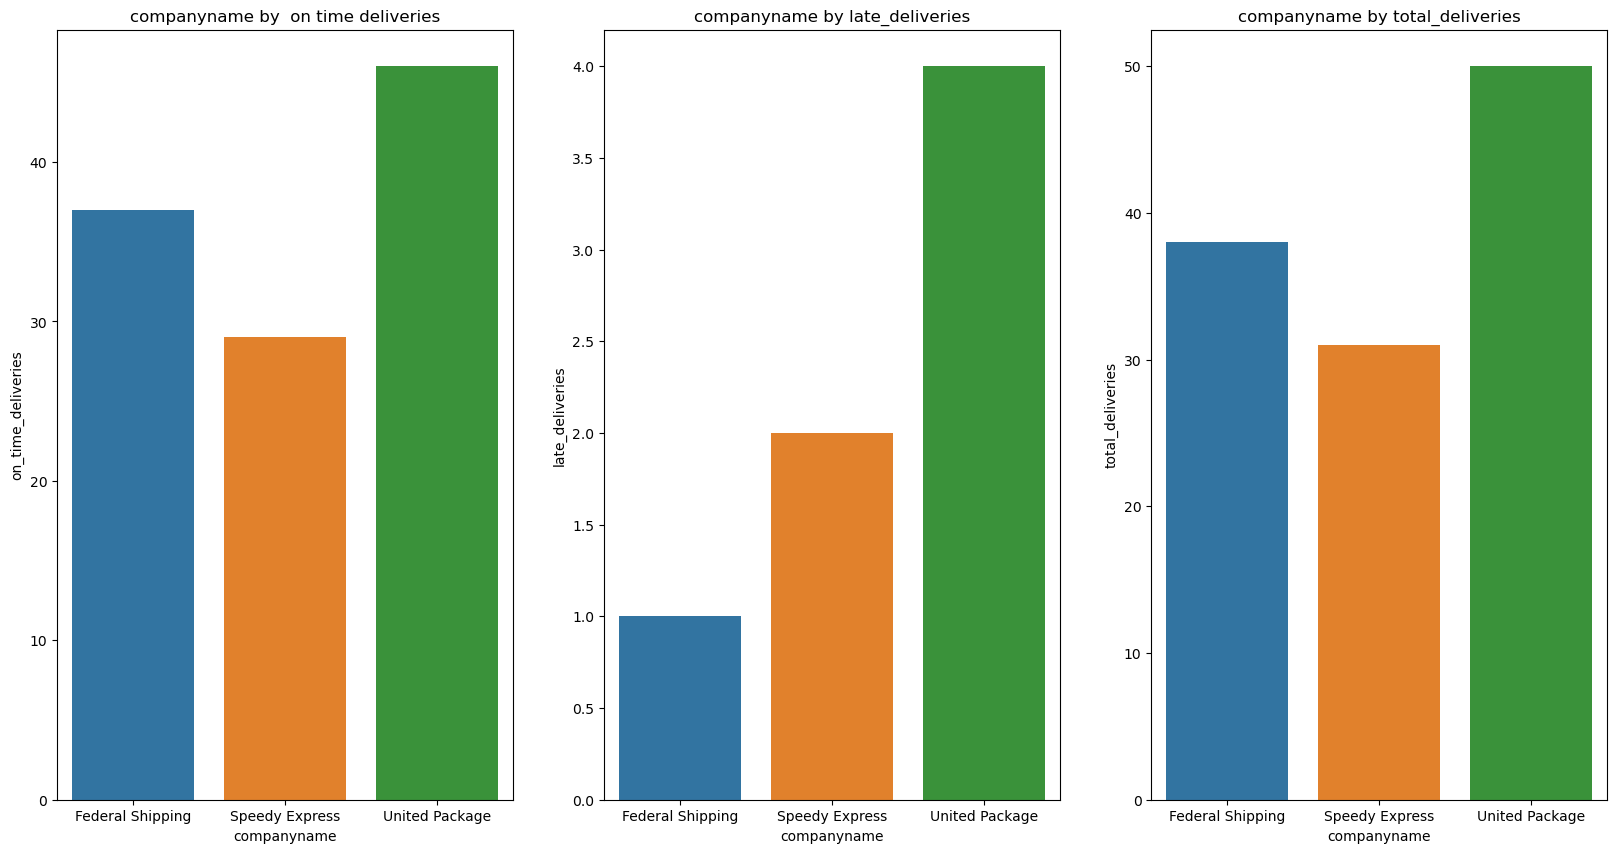

In [31]:
# visualization

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,10))
sns.barplot(delivery_performance_df, x = 'companyname', y = 'on_time_deliveries', ax=axes[0])
sns.barplot(delivery_performance_df, x='companyname', y='late_deliveries', ax=axes[1])
sns.barplot(delivery_performance_df, x='companyname', y='total_deliveries', ax=axes[2])

axes[0].set_title('companyname by  on time deliveries')
axes[1].set_title('companyname by late_deliveries')
axes[2].set_title('companyname by total_deliveries')


Text(0.5, 1.0, 'companyname by late delivery rate')

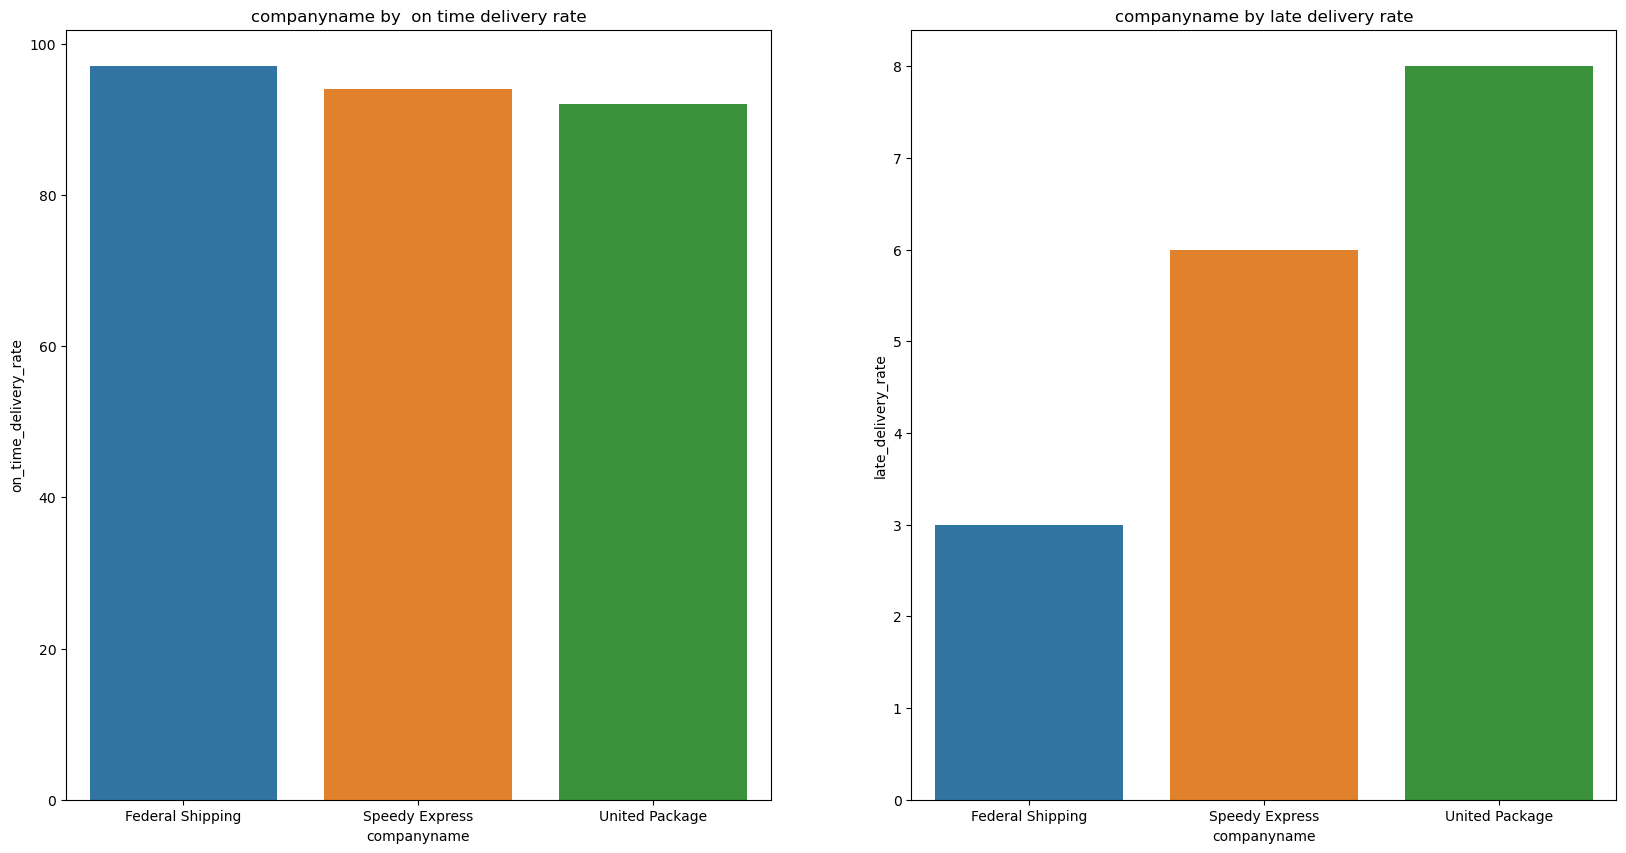

In [35]:
# visualization of on time delivery rate and late delivery rate vs company name

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
sns.barplot(delivery_performance_rate_df, x = 'companyname', y = 'on_time_delivery_rate', ax=axes[0])
sns.barplot(delivery_performance_rate_df, x='companyname', y='late_delivery_rate', ax=axes[1])


axes[0].set_title('companyname by  on time delivery rate')
axes[1].set_title('companyname by late delivery rate')


### FINDINGS

On-Time Delivery Rates:

Federal Shipping has the highest on-time delivery rate at 97% (37 on-time deliveries out of 38 total).

Speedy Express has a slightly lower on-time delivery rate at 94% (29 on-time deliveries out of 31 total).

United Package has the lowest on-time delivery rate at 92% (46 on-time deliveries out of 50 total).


Late Delivery Rates:

Federal Shipping has the lowest late delivery rate at 3% (1 late delivery).

Speedy Express has a 6% late delivery rate (2 late deliveries).

United Package has an 8% late delivery rate (4 late deliveries).


Overall Conclusion:

Based on this sample data, Federal Shipping appears to have the best overall delivery performance with the highest on-time delivery rate and the lowest late delivery rate. However, it's important to consider some limi ations:

Sample Size: This data represents a small sample and may not reflectperformanceanies' overall performan

Delivery Factors Not Considered: Other factors like shipment type, distance traveled and unforeseen circumstances cavery time delivery times.

 ### EXPLORATORY DATA ANALYSIS
 2. understanding the factors contributing significantly to late deliveries

In [44]:
late_delivery_query= '''
select distinct s.companyname as `shipping company`, c.country as `customer destination`, o.freight as `freight cost`, 
od.quantity as `order quantity`,
abs(datediff(requireddate, shippeddate)) as `late delivery days`  from orders o
join customers c on c.customerid = o.customerid
join shippers s on o.shipvia = s.shipperid
join `order details` od on o.orderid = od.orderid
where datediff(requireddate, shippeddate) < 0;
'''

data = read_query(query=late_delivery_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

late_delivery_df = pd.DataFrame(data=data_list, columns=['shipping company', 'customer destination', 'freight cost', 'order quantity',
                                                                'late delivery days'])
late_delivery_df

,shipping company,customer destination,freight cost,order quantity,late delivery days
0,Speedy Express,Sweden,8.9800,12,1
1,Speedy Express,Sweden,8.9800,20,1
2,Speedy Express,Sweden,8.9800,30,1
3,Speedy Express,Ireland,47.3000,20,6
4,Speedy Express,Ireland,47.3000,30,6
...,...,...,...,...,...
81,Federal Shipping,USA,487.5700,12,5
82,Federal Shipping,USA,487.5700,60,5
83,Federal Shipping,USA,487.5700,36,5
84,Federal Shipping,USA,487.5700,45,5


In [46]:
#inspect null values
late_delivery_df.isnull().sum()

shipping company        0
customer destination    0
freight cost            0
order quantity          0
late delivery days      0
dtype: int64

In [48]:
# inspect the data qualities
late_delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   shipping company      86 non-null     object
 1   customer destination  86 non-null     object
 2   freight cost          86 non-null     object
 3   order quantity        86 non-null     int64 
 4   late delivery days    86 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 3.5+ KB


In [50]:
late_delivery_df['freight cost'] = pd.to_numeric(late_delivery_df['freight cost'], errors='coerce')

In [52]:
# inspect the data qualities
late_delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   shipping company      86 non-null     object 
 1   customer destination  86 non-null     object 
 2   freight cost          86 non-null     float64
 3   order quantity        86 non-null     int64  
 4   late delivery days    86 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 3.5+ KB


Text(0.5, 1.0, 'customer destination vs late delivery days')

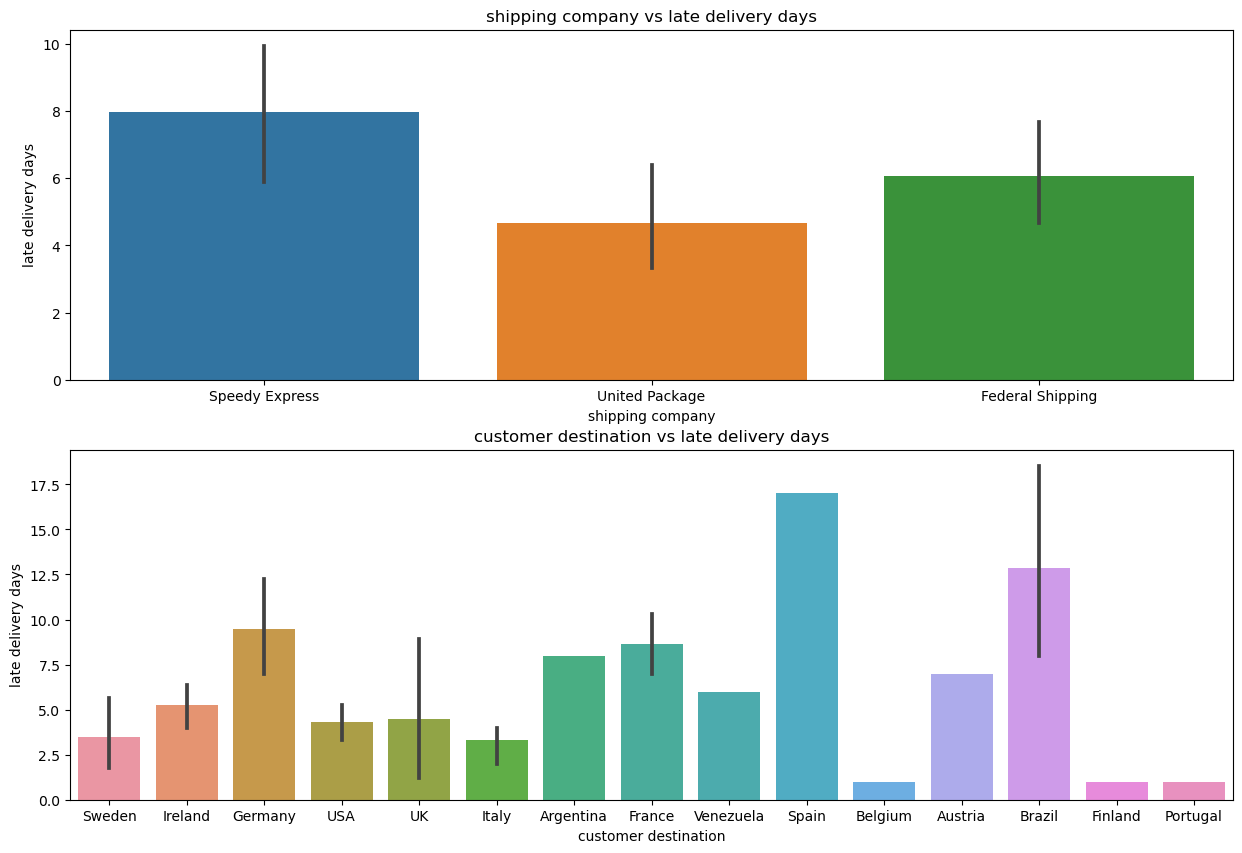

In [54]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(15,10))
sns.barplot(data=late_delivery_df, x = 'shipping company', y = 'late delivery days' , ax = axes[0])
sns.barplot(data=late_delivery_df, x = 'customer destination', y = 'late delivery days', ax = axes[1])

axes[0].set_title('shipping company vs late delivery days')
axes[1].set_title('customer destination vs late delivery days')

In [56]:
from scipy import stats

In [58]:
# Data Exploration
print(late_delivery_df.describe())  # Summary statistics

       freight cost  order quantity  late delivery days
count     86.000000       86.000000           86.000000
mean     123.816860       25.186047            6.116279
std      159.286527       21.776680            4.980949
min        1.360000        1.000000            1.000000
25%       16.395000       10.500000            2.000000
50%       61.530000       20.000000            6.000000
75%      185.367500       30.000000            7.000000
max      719.780000      120.000000           23.000000


<Axes: >

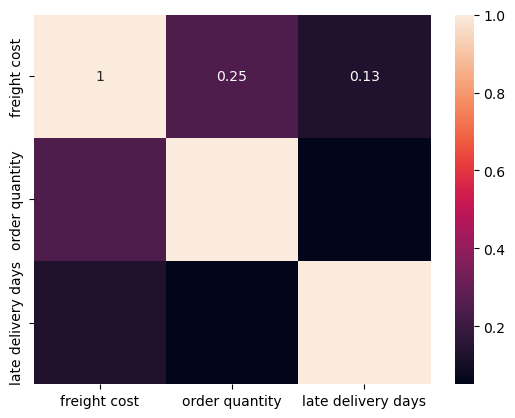

In [60]:
# correlation

corr_df = late_delivery_df[['freight cost','order quantity','late delivery days']].corr(method='spearman')
sns.heatmap(data=corr_df, annot=True)

In [62]:
# Select numerical columns
numeric_cols = ['freight cost','order quantity','late delivery days']
correlation_matrix = late_delivery_df[numeric_cols].corr()

# Display correlation matrix (consider using heatmap for visualization)
print(correlation_matrix)

                    freight cost  order quantity  late delivery days
freight cost            1.000000        0.334860           -0.087305
order quantity          0.334860        1.000000            0.188088
late delivery days     -0.087305        0.188088            1.000000


### FINDINGS
The analysis revealed weak correlations between late delivery days, freight cost, and order quantity. While no statistically significant
relationships were found, the Spearman correlation coefficient suggests a potential weak association between order quantity and late delivery days.
Further research with a larger sample size could provide more statistical power to detect this potential correlation and confirm or refute it. 
Additionally, investigating the impact of other factors  on late delivery days might be valuable.

### ANOVA

In [64]:
from scipy.stats import f_oneway

In [66]:
# function

def decision_rules(p_value, variables):
    null = f'At p-value = {anova_results.pvalue}, there is no significant difference in groups'
    alternative =f'At p-value = {anova_results.pvalue}, there is significant difference in groups'
    if anova_results.pvalue < 0.05:
        return alternative
    else:
        return null

In [68]:
# one way anova test for difference in claim customer destination vs late delivery days

df = pd.DataFrame(late_delivery_df)

# group data by country
groups = df.groupby('customer destination')['late delivery days'].apply(list)

# one way anova
anova_results = f_oneway(*groups)


print('ANOVA F-statistic:',anova_results.statistic)
print('ANOVA p-value:',anova_results.pvalue)
print(decision_rules(anova_results.pvalue,[groups]))

ANOVA F-statistic: 3.580076817078428
ANOVA p-value: 0.00018252152429517696
At p-value = 0.00018252152429517696, there is significant difference in groups


### FINDINGS
Based on the results of the one-way ANOVA, we reject the null hypothesis and conclude that there is a statistically significant 
relationship between customer destination and the number of late delivery days. This indicates that the destination of the customer 
has an impact on the likelihood of experiencing late deliveries. Further analysis is warranted to determine the specific factors within 
customer destinations that influence delivery times.

In [70]:
# one way anova test for difference in claim shipping company vs late delivery days

df = pd.DataFrame(late_delivery_df)

# group data by country
groups = df.groupby('shipping company')['late delivery days'].apply(list)

# one way anova
anova_results = f_oneway(*groups)


print('ANOVA F-statistic:',anova_results.statistic)
print('ANOVA p-value:',anova_results.pvalue)
print(decision_rules(anova_results.pvalue,[groups]))

ANOVA F-statistic: 3.466991762666534
ANOVA p-value: 0.03580155340775216
At p-value = 0.03580155340775216, there is significant difference in groups


### FINDINGS
Based on the ANOVA results, we reject the null hypothesis and conclude that there is a statistically significant difference in mean 
late delivery days among three different shipping companies. This suggests that the shipping company a customer chooses may have an impact 
on the average number of days their package is late.

# KEY FINDINGS:

The data analysis revealed that order quantity and freight cost have minimal impact on late delivery days, as evidenced by the weak and statistically
insignificant correlations. However, two significant factors emerged: customer destination and shipping company

#### 1. Customer Destination:
Location plays a crucial role. Distance and local infrastructure likely influence late delivery rates.
    
#### 2. Shipping Company: 
The choice of shipping company significantly impacts the average number of late deliveries, indicating performance variations across companies.


#### Actionable Recommendations:

#### 1. Prioritize Distance-Based Strategies:
Analyze how distance zones affect delivery times. Consider optimizing routes or shipping methods (e.g., expedited options) for zones with higher late delivery rates.
#### 2. Investigate Local Infrastructure Challenges:
Identify high-risk destination regions with specific infrastructure issues (e.g., customs delays, limited transportation options). Explore solutions like partnering with local delivery providers to improve efficiency.
#### 3.  Deep Dive into Shipping Company Performance: Analyze variations among companies, focusing on:
   (a) Service Level Correlation: Investigate if specific service levels (e.g., priority shipping) correlate with lower late deliveries for 
        high-risk destinations.
        
   (b) Regional Performance Analysis: Evaluate how company performance varies across regions. Partner with companies demonstrating strong 
        performance in key customer destination areas.
        
   (c) Customer Satisfaction Integration: Incorporate customer feedback on delivery times for each company to identify areas for improvement
        within the shipping company selection process. 
#### 4. Explore Additional Influencing Factors:
   (a) Product Characteristics: Analyze how size, weight, and special handling requirements might impact delivery complexity and potential delays.
    This could involve segmenting data by product type.
    
   (b) Seasonal Variations: Identify peak periods or weather-related trends that might influence delivery times. This could involve time series 
     analysis to uncover seasonal patterns.

#### Intriguing Possibility: Strategic Shipping Locations

While not directly explored in this analysis, the concept of having a shipping country physically closer to the customer destination is intriguing. Potentially, this could benefit delivery times by reducing distance and leveraging better local infrastructure. However, further research is needed to assess the feasibility and cost-effectiveness within the specific context of our shipping network.  This would involve analyzing regulations and potential cost variations associated with different origin countries.

Conclusion: By implementing these recommendations and potentially exploring strategically located shipping countries based on further research, 
we can gain a deeper understanding of the factors influencing late deliveries. This knowledge can be used to make data-driven decisions to improve 
delivery timeliness and enhance customer satisfaction.

## 3. understanding factors contributing more to revenue or affecting revenue

In [72]:
product_category_query= '''
select pc.CategoryName as product_Category, count(*) as number_of_orders, round(sum(od.UnitPrice * od.Quantity),0) as TotalRevenue
from Products p
join `Order Details` od ON p.ProductID = od.ProductID
join  Categories pc ON p.CategoryID = pc.CategoryID
group by pc.CategoryName
order by TotalRevenue DESC;
'''

data = read_query(query=product_category_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

product_category_df = pd.DataFrame(data=data_list, columns=['product category', 'number of orders', 'TotalRevenue'])
product_category_df


,product category,number of orders,TotalRevenue
0,Beverages,404,286527
1,Dairy Products,366,251331
2,Meat/Poultry,173,178189
3,Confections,334,177099
4,Seafood,330,141623
5,Condiments,216,113695
6,Produce,136,105269
7,Grains/Cereals,196,100727


In [74]:
# inspect the data qualities
product_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product category  8 non-null      object
 1   number of orders  8 non-null      int64 
 2   TotalRevenue      8 non-null      object
dtypes: int64(1), object(2)
memory usage: 324.0+ bytes


In [76]:

# Specify desired data types

convert_dict = {'TotalRevenue': int}  
product_category_df = product_category_df.astype(convert_dict)

In [78]:
product_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product category  8 non-null      object
 1   number of orders  8 non-null      int64 
 2   TotalRevenue      8 non-null      int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 292.0+ bytes


In [80]:
# Descriptive Statistics (Example)
print("Average Order Value:", round(product_category_df['TotalRevenue'].mean(), 2))

Average Order Value: 169307.5


In [82]:
# Data Exploration
print(product_category_df.describe())  # Summary statistics

       number of orders  TotalRevenue
count          8.000000       8.00000
mean         269.375000  169307.50000
std          100.443214   68942.26405
min          136.000000  100727.00000
25%          190.250000  111588.50000
50%          273.000000  159361.00000
75%          342.000000  196474.50000
max          404.000000  286527.00000


Text(0.5, 1.0, 'product category vs number of orders')

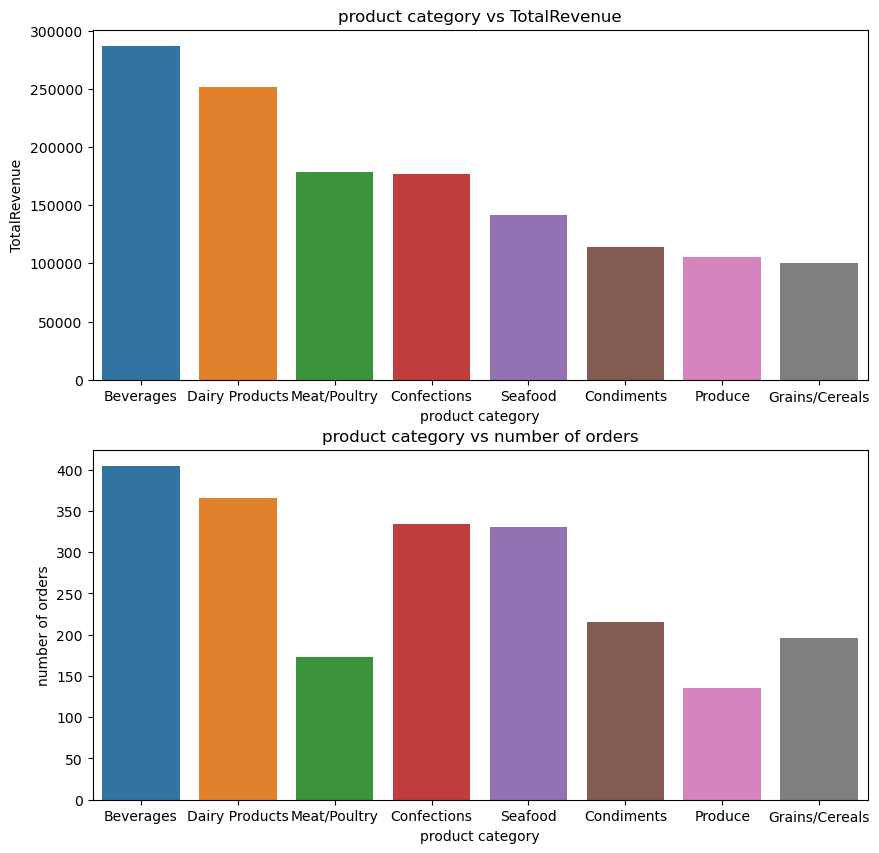

In [84]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(10,10))
sns.barplot(data=product_category_df, x = 'product category', y = 'TotalRevenue' , ax = axes[0])
sns.barplot(data=product_category_df, x = 'product category', y = 'number of orders', ax = axes[1])

axes[0].set_title('product category vs TotalRevenue')
axes[1].set_title('product category vs number of orders')


## FINDINGS

Top Product Categories by Number of Orders: The top three product categories by number of orders are "Beverages" (404 orders), "Dairy Products" 
(366 orders), and "Meat/Poultry" (173 orders). These categories represent the most popular selections among customers.

In [86]:
customer_country_query= '''

SELECT c.Country as customer_country, count(*) as number_of_orders, round(SUM(od.UnitPrice * od.Quantity),0) AS TotalRevenue
FROM Orders o
JOIN `Order Details` od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
GROUP BY c.Country
ORDER BY TotalRevenue DESC;
'''

data = read_query(query=customer_country_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

customer_country_df = pd.DataFrame(data=data_list, columns=['customer country', 'number of orders', 'TotalRevenue'])
customer_country_df

,customer country,number of orders,TotalRevenue
0,USA,352,263567
1,Germany,314,241401
2,Austria,125,139497
3,Brazil,203,114968
4,France,184,85499
5,UK,149,63856
6,Venezuela,118,60815
7,Sweden,97,59524
8,Ireland,55,57317
9,Canada,75,55334


In [88]:
# inspect the data qualities
customer_country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer country  21 non-null     object
 1   number of orders  21 non-null     int64 
 2   TotalRevenue      21 non-null     object
dtypes: int64(1), object(2)
memory usage: 636.0+ bytes


In [90]:
customer_country_df['TotalRevenue'] = pd.to_numeric(customer_country_df['TotalRevenue'], errors='coerce')

In [92]:
customer_country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer country  21 non-null     object 
 1   number of orders  21 non-null     int64  
 2   TotalRevenue      21 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 636.0+ bytes


Text(0.5, 1.0, 'customer country vs number of orders')

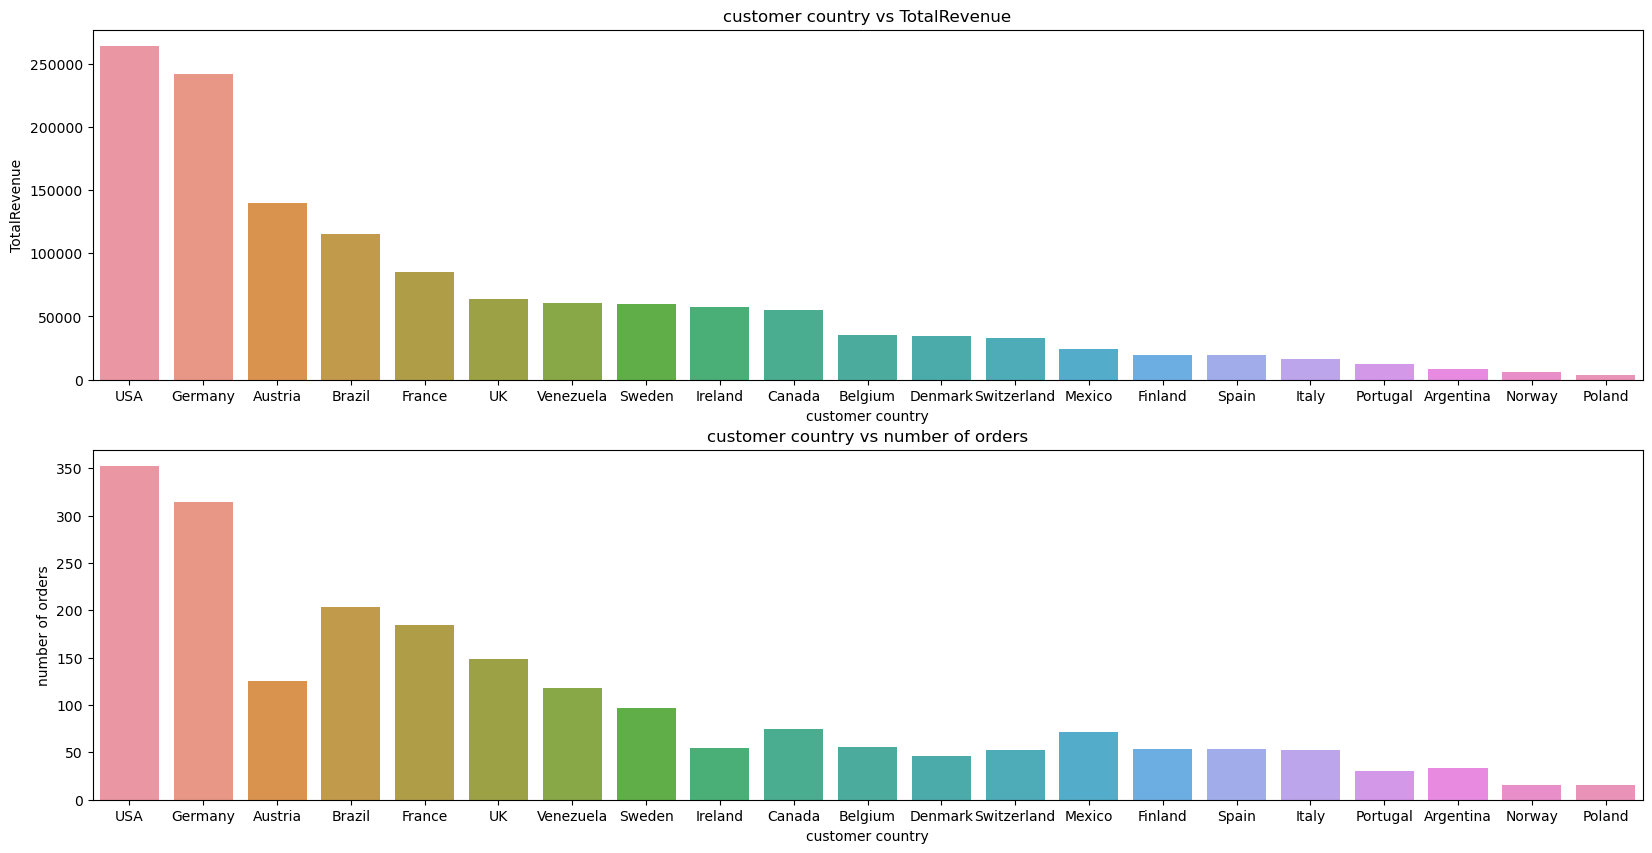

In [94]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))
sns.barplot(data=customer_country_df, x = 'customer country', y = 'TotalRevenue' , ax = axes[0])
sns.barplot(data=customer_country_df, x = 'customer country', y = 'number of orders', ax = axes[1])

axes[0].set_title('customer country vs TotalRevenue')
axes[1].set_title('customer country vs number of orders')


## FINDINGS

Top Countries by Order Count: The United States (352 orders) has the most orders, followed by Germany (314 orders) and Brazil(203 orders).

Top Countries by Revenue: The United States also has the highest total revenue (263,567), followed by Germany (241,401) and Austria (139497).



<Axes: >

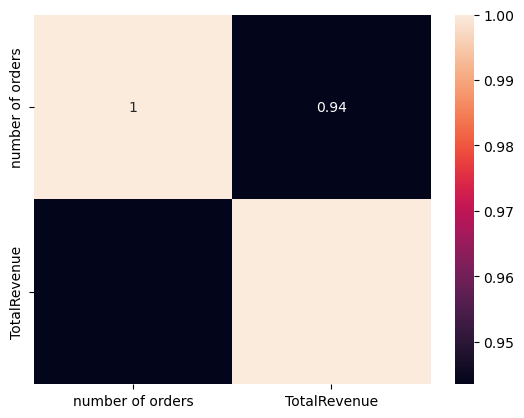

In [98]:
# correlation

corr_df = customer_country_df[['number of orders', 'TotalRevenue']].corr(method='spearman')
sns.heatmap(data=corr_df, annot=True)

In [100]:
# Select numerical columns
numeric_cols = ['number of orders', 'TotalRevenue']
correlation_matrix = customer_country_df[numeric_cols].corr()

# Display correlation matrix (consider using heatmap for visualization)
print(correlation_matrix)

                  number of orders  TotalRevenue
number of orders          1.000000      0.953524
TotalRevenue              0.953524      1.000000


# FINDINGS

Based on the strong correlation coefficients and highly significant p-values, we can reject the null hypothesis and conclude that there is a 
statistically significant positive correlation between 'number_of_orders' and 'TotalRevenue'. This suggests that as the number of orders increases, 
there is a notable increase in TotalRevenue generated.

## General Findings
1. Top Product Categories by Number of Orders:

   The most popular product categories are "Beverages" (404 orders), "Dairy Products" (366 orders), and "Meat/Poultry" (173 orders).
   
   These categories are the primary contributors to the volume of orders.
   

2. Top Countries by Order Count:
   
   The United States leads with 352 orders, followed by Germany (314 orders) and Brazil (203 orders).
   
   These countries are significant markets in terms of order volume.
   

3. Top Countries by Revenue:
   
   The United States generates the highest total revenue (263,567), followed by Germany (241,401) and Austria (139,497)dollars.
   
   This indicates that these countries are not only ordering frequently but also generating substantial revenue.
   

5. Correlation between Number of Orders and Total Revenue:
   
   There is a statistically significant positive correlation between the number of orders and total revenue.
   
   As the number of orders increases, total revenue also rises significantly.

Conclusion:

The analysis reveals that the volume of orders, particularly from specific product categories and countries, is a major factor contributing to total revenue. The strong correlation between the number of orders and total revenue underscores the importance of increasing order volume to drive higher revenue. Focusing on top-performing product categories and key markets like the United States, Germany, and Austria  an be stegic in enhancing revenue.


hancing revenue.

